In [14]:
import numpy as np
import pandas as pd
import os 
import sys
import time
import matplotlib.pyplot as plt

# 벤다이어그램용
%matplotlib inline
import venn

In [21]:
class DataPreprocess:
    
    def __init__(self, region):
        
        self.path = os.getcwd()
        self.path = os.path.dirname(self.path)
        self.path = os.path.dirname(self.path)
        self.path= self.path + f'\\region\\{region}' #'\\region\\{}'.format(region) 
        self.region = region

    def makeDir(self):
        self.newPath = os.path.join(f'{self.path}\\PreprocessData') 
         
        if not os.path.exists(self.newPath):
            os.makedirs(os.path.join(f'{self.path}\\PreprocessData'))
        else:
            print('이미 존재합니다.')
        
        # 0_ 은 파일리스트 뽑을 때 commonPatientID 디렉토리를 맨 앞에 두기 위해서 해놓음.
    
    def dataSet(self):
        #filelist 부분을 합침
        self.fileList = os.listdir(self.path)[1:] 
        file_list = []
        for filename in self.fileList:
            # 파일명이 문자열을 포함하는지 확인
            if self.region in filename:
                file_list.append(filename)
        self.fileList = file_list
        self.dataDict = {}
        for i in self.fileList:
            self.dataDict[i] = pd.read_csv(self.path+'\\{}'.format(i), encoding = 'utf-16', index_col = 0)
        print('All files are added')
        return self.dataDict
    
    # Tmedication에는 환자정보와 시간이 없어서 만들기위해 TMedicalRecord와 MedicalRecordID를 key로서 사용하여 연결
    def Tmedication(self):
        
        #2024 버전의 데이터에 맞춰 변경
        temp = self.dataDict[f'{self.region}_tmedicalrecord.csv'][['MedicalRecordID','PatientID']]

        
        #저장하는 형식으로 코드 수정
        self.dataDict['{}_tmedication.csv'.format(self.region)] = \
            pd.merge(temp,self.dataDict['{}_tmedication.csv'.format(self.region)], how = 'inner', on = 'MedicalRecordID')
        return self.dataDict['{}_tmedication.csv'.format(self.region)]

        
        
    def patientChartNo(self):
        self.dataDict[f'{self.region}_tpatientpersonal.csv'] = \
        self.dataDict[f'{self.region}_tpatientpersonal.csv'].loc[self.dataDict[f'{self.region}_tpatientpersonal.csv']['PatientChartNo'].notnull()]

    def countUniquePatientID(self):
        for i in self.dataDict.keys():
            sheetPatientIDSet = self.dataDict[i]['PatientID']
            print(f'{i} sheetPatientIDSet,{len(sheetPatientIDSet)}')
            sheetPatientIDSet = set(self.dataDict[i]['PatientID'])
            print(f'{i} sheetPatientIDSet,{len(sheetPatientIDSet)}')

    def vennDiagram(self):
        self.inbodySet        = set(self.dataDict['{}_tinbodyadditionaldata.csv'.format(self.region)]['PatientID'])
        self.privateSet       = set(self.dataDict[f'{self.region}_tpatientpersonal.csv']['PatientID'])
        self.medicationSet    = set(self.dataDict['{}_tmedication.csv'.format(self.region)]['PatientID'])
        self.medicalRecordSet = set(self.dataDict['{}_tmedicalrecord.csv'.format(self.region)]['PatientID'])
        self.vitalTempSet     = set(self.dataDict['{}_tpatientvitaltemp.csv'.format(self.region)]['PatientID'])
    
        self.labels = venn.get_labels([self.inbodySet,self.privateSet,self.medicationSet,self.medicalRecordSet,self.vitalTempSet])
        # augument 로 fill을 안써도 되는구나 ( pilot 보면 여기에 써놓음)
        plt.figure(figsize=(12,8))
        fig,ax = venn.venn5(self.labels,names = ['inbody','private','medication','medicalRecord','vitalTemp'])
        plt.title(f'{self.region}')
        plt.show()
        plt.close()

    def makeInbody(self):
        #파일 리스트를 만들고 문제가 있는 파일 제거
        #impedence와 measurement는 plat작업이 필요
        #obestity는 인덱스 에러(?)
        inbody_file_names = self.fileList[0:14]
        inbody_file_names.remove(f'{self.region}_tinbodyimpedence.csv')
        inbody_file_names.remove(f'{self.region}_tinbodymeasurement.csv')
        inbody_file_names.remove(f'{self.region}_tinbodyobesitydiagnosis.csv')

        for i, name in enumerate(inbody_file_names):
            df = self.dataDict[name]
            df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
            df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)
            print()
            print(i, name, len(df))
            if i == 0 :
                inbody_total_df = df
        
            else:
                df.drop(columns=['ReadingID'], inplace=True)
                df_columns = set(df.columns)
                total_columns = set(inbody_total_df.columns)
                common_feature = list(df_columns & total_columns)
                print(common_feature)
                inbody_total_df =pd.merge(inbody_total_df, df, on = common_feature)
                print(len(inbody_total_df))
        print(inbody_total_df.shape)
        print(inbody_total_df.head())

        #measurment part
        df = self.dataDict[f'{self.region}_tinbodymeasurement.csv']
        df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
        df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)
        df = df.iloc[:,1:12]

        #measurment feature 생성
        feature_names = df.columns[3:]
        neck_feature_names = ['neck_'+ name for name in feature_names]
        chest_feature_names = ['chest_'+ name for name in feature_names]
        abdomen_feature_names = ['abdomen_'+ name for name in feature_names]
        hip_feature_names = ['hip_'+ name for name in feature_names]
        Larm_feature_names = ['Larm_'+ name for name in feature_names]
        Rarm_feature_names = ['Rarm_'+ name for name in feature_names]
        Lleg_feature_names = ['Lleg_'+ name for name in feature_names]
        Rleg_feature_names = ['Rleg_'+ name for name in feature_names]

        for i in range(len(df)):
            if i % 8 == 0:
                imsi_dict = {'PatientID': df.loc[0,'PatientID'], 'MeasureDate' : df.loc[0,'MeasureDate']}
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {neck_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 1:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {chest_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 2:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {abdomen_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 3:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {hip_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 4:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Larm_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 5:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Rarm_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 6:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Lleg_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
            elif i % 8 == 7:
                imsi_list=list(df.loc[i][3:])
                imsi_dict2 = {Rleg_feature_names[i]:[imsi_list[i]] for i in range(8)}
                imsi_dict.update(imsi_dict2)
                
            if i < 7:
                continue
            elif i == 7:
                mesurment_df = pd.DataFrame(imsi_dict)
            elif i % 8 == 7:
                imsi_df = pd.DataFrame(imsi_dict)
                mesurment_df = pd.concat([mesurment_df, imsi_df])
            mesurment_df.reset_index(inplace=True, drop=True)
            
        print(mesurment_df.shape)
        print(mesurment_df.head())

        #병합
        inbody_total_df =pd.concat([inbody_total_df,mesurment_df.iloc[:,2:]], axis =1)

        #impedence part
        df = self.dataDict[f'{self.region}_tinbodyimpedence.csv']
        df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
        df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)

        #freq 기준으로 feature 만듬
        feature_names = df.columns[4:9]
        feature_names1 = ['1_'+ name for name in feature_names]
        feature_names5 = ['5_'+ name for name in feature_names]
        feature_names50 = ['50_'+ name for name in feature_names]
        feature_names250 = ['250_'+ name for name in feature_names]
        feature_names500 = ['500_'+ name for name in feature_names]
        feature_names1000 = ['1000_'+ name for name in feature_names]

        for i in range(len(df)):
            if i % 6 == 0:
                imsi_dict = {'PatientID': df.loc[0,'PatientID'], 'MeasureDate' : df.loc[0,'MeasureDate']}
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names1[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 1:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names5[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 2:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names50[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 3:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names250[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 4:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names500[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
            elif i % 6 == 5:
                imsi_list=list(df.loc[i][4:9])
                imsi_dict2 = {feature_names1000[i]:[imsi_list[i]] for i in range(5)}
                imsi_dict.update(imsi_dict2)
                
            if i < 5:
                continue
            elif i == 5:
                impedence_df = pd.DataFrame(imsi_dict)
            elif i % 6 == 5:
                imsi_df = pd.DataFrame(imsi_dict)
                impedence_df = pd.concat([impedence_df, imsi_df])
        
        impedence_df.reset_index(inplace=True, drop=True)
        print(impedence_df.shape)
        print(impedence_df.head())
        inbody_total_df = pd.concat([inbody_total_df, impedence_df.iloc[:,2:]], axis = 1)

        #obesitydiagnosis part
        df = self.dataDict[f'{self.region}_tinbodyobesitydiagnosis.csv']
        df['MeasureDate'] = pd.to_datetime(df['MeasureDate'], format='%Y%m%d%H%M%S')
        df = df.sort_values(by=['PatientID', 'MeasureDate']).reset_index(drop=True)
        df.drop(columns=['ReadingID'], inplace=True)
        df = df.drop('PSMM', axis=1)
        df = df.drop('PWeight', axis=1)
        df = df.drop('Weight', axis=1)
        df = df.drop('ReadingID_ORG', axis=1)

        inbody_total_df = pd.merge(inbody_total_df, df, on = ['MeasureDate', 'PatientID'])
        print(inbody_total_df.shape)
        print(inbody_total_df.head())

        self.inbody_total_df = inbody_total_df
        return(self.inbody_total_df)



    def saveDataFrame(self):            
        self.newPath = os.path.join(f'{self.path}\\PreprocessData')
        
        #inbody
        self.inbody_df.to_csv(f'{self.newPath}\\{self.region}_inbody.csv', index=False)
        self.inbody_df.to_excel(f'{self.newPath}\\{self.region}_inbody.xlsx', index=False)
        print(f'{self.region}_inbody_df 저장완료')
        
        #medical
        self.medical_df.to_csv(f'{self.newPath}\\{self.region}_medical.csv', index=False)
        self.medical_df.to_excel(f'{self.newPath}\\{self.region}_medical.xlsx', index=False)
        print(f'{self.region}_medical_df 저장완료')
        
        #vital    
        self.vital_df.to_csv(f'{self.newPath}\\{self.region}_vital.csv', index=False)
        self.vital_df.to_excel(f'{self.newPath}\\{self.region}_vital.xlsx', index=False)
        print(f'{self.region}_vital_df 저장완료')

    def saveMergeData(self):
        #merge
        self.merge_df.to_csv(f'{self.newPath}\\{self.region}_merge.csv', index=False)
        self.merge_df.to_excel(f'{self.newPath}\\{self.region}_merge.xlsx', index=False)
        print(f'{self.region}_merge_df 저장완료')
        

    def loadPreprocessData(self):
        
        self.newPath = os.path.join(f'{self.path}\\PreprocessData')
        try:
            self.inbody_df = pd.read_csv(f'{self.newPath}\\{self.region}_inbody.csv')
            print(f"{self.region}_inbody_df 로드 완료")
        except Exception as e:
            # 에러 발생 시 실행할 코드 작성
            print(f"{self.region}_inbody_df 로드 실패")
            pass 
            
        try:
            self.medical_df = pd.read_csv(f'{self.newPath}\\{self.region}_medical.csv')
            print(f"{self.region}_medical_df 로드 완료")
        except Exception as e:
            # 에러 발생 시 실행할 코드 작성
            print(f"{self.region}_medical_df 로드 실패")
            pass 
            
        try:
            self.vital_df = pd.read_csv(f'{self.newPath}\\{self.region}_vital.csv')
            print(f"{self.region}_vital_df 로드 완료")
        except Exception as e:
            # 에러 발생 시 실행할 코드 작성
            print(f"{self.region}_vital_df 로드 실패")
            pass 

        try:
            self.merge_df = pd.read_csv(f'{self.newPath}\\{self.region}_merge.csv')
            print(f"{self.region}_merge_df 로드 완료")
        except Exception as e:
            # 에러 발생 시 실행할 코드 작성
            print(f"{self.region}_merge_df 로드 실패")
            pass 
            
    def makeMerge(self):
        df_path = os.path.join(f'{self.path}\\PreprocessData\\{self.region}_merge.csv')
        if os.path.exists(df_path):
            raise FileExistsError(f"'vital' 파일이 {self.region} PreprocessData 디렉토리에 이미 존재합니다.")

        
        #데이터 로드
        #저장된 파일을 로드하지 않으면 timestamp error가 발생생
        inbody_df = self.inbody_df
        medical_df = self.medical_df
        vital_df = self.vital_df

        #전처리
        medical_df.drop('CrTime',axis =1, inplace =True)
        medical_df.drop('Weight',axis =1, inplace =True)
        medical_df['Date'] = medical_df['ConsultTime'].apply(lambda x: x.split()[0])
        inbody_df['Date'] = inbody_df['MeasureDate'].apply(lambda x: x.split()[0])
        vital_df['Date'] = vital_df['CheckDate'].apply(lambda x: x.split()[0])
        merge_df = pd.merge(medical_df, inbody_df, on=['PatientID', 'Date'], how = 'outer')
        merge_df = pd.merge(merge_df, vital_df, on=['PatientID', 'Date'], how = 'outer')

        #반복측정 제거 과
        group_df = merge_df.groupby(['PatientID', 'Date'])
        group_size = merge_df.groupby(['PatientID', 'Date']).size()
        overlab_list = group_size[group_size != 1].index.tolist()

        copy_df =merge_df.copy()

        for ID, Date in overlab_list:
            imsi_df = merge_df[merge_df['PatientID']==ID][merge_df['Date'] == Date]
            remove_date_list = list(imsi_df['MeasureDate'])
            max_index =imsi_df['MeasureDate'].max()
            remove_date_list.remove(max_index)
            copy_df = copy_df[~((copy_df['PatientID']==ID) & (copy_df['Date'] == Date) & (copy_df['MeasureDate'].isin(remove_date_list)))]

        self.merge_df = copy_df

        return self.merge_df
        
                
        
                


In [22]:
incheon = DataPreprocess(region = 'bucheon')

In [23]:
incheon.makeDir()
incheon.loadPreprocessData()

이미 존재합니다.
bucheon_inbody_df 로드 완료


C:\Users\howsr\AppData\Local\Temp\ipykernel_22092\2085843226.py:282: DtypeWarning: Columns (29,55,64) have mixed types. Specify dtype option on import or set low_memory=False.
  self.medical_df = pd.read_csv(f'{self.newPath}\\{self.region}_medical.csv')


bucheon_medical_df 로드 완료
bucheon_vital_df 로드 완료


C:\Users\howsr\AppData\Local\Temp\ipykernel_22092\2085843226.py:298: DtypeWarning: Columns (28,54,62) have mixed types. Specify dtype option on import or set low_memory=False.
  self.merge_df = pd.read_csv(f'{self.newPath}\\{self.region}_merge.csv')


bucheon_merge_df 로드 완료


In [26]:
inbody_df = incheon.inbody_df
medical_df = incheon.medical_df
vital_df = incheon.vital_df
merge_df = incheon.merge_df

In [27]:
merge_df[merge_df['PatientID']==1367]

,MedicalRecordID,PatientID,ScheduleID,ConsultTime,ConsultNote,ProgressNote,Summary,RequestI,RequestII,TreatmentCat,...,BMI,SMM,BodyFat,VFA,WHR,CheckDate,CrTime,MaxVital,MinVital,Pulse
496,1135570.0,1367,1410690.0,2023-11-27 11:55:00,NaN,# 비만(전화접수)\n\n★3개월미만 미내원 의료진 확인사항 \n현재체중 : 65k...,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
inbody_set = set(inbody_df['PatientID'])
medical_set = set(medical_df['PatientID'])
vital_set = set(vital_df['PatientID'])

In [29]:
labels = venn.get_labels([inbody_set, medical_set, vital_set])

<Figure size 1200x800 with 0 Axes>

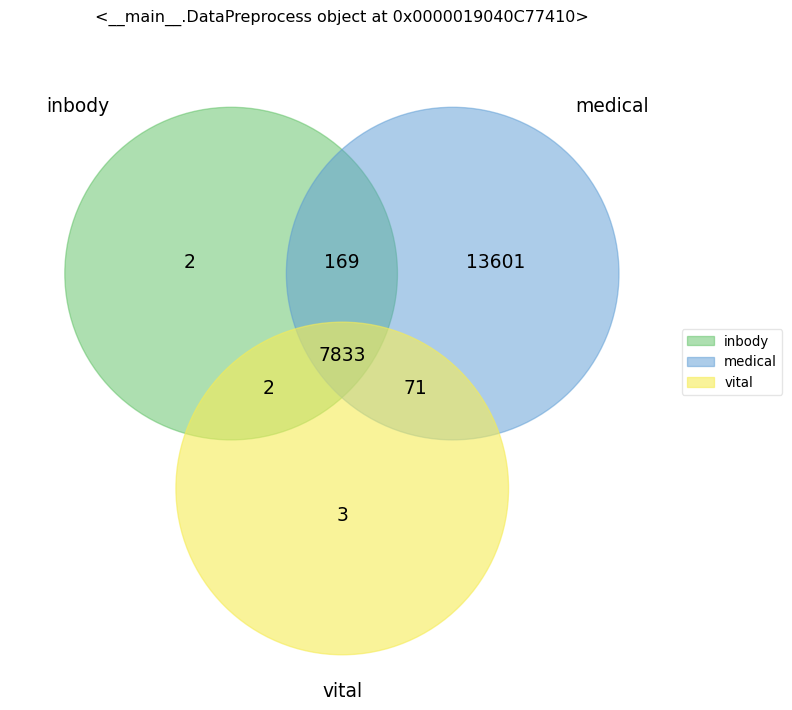

In [30]:
plt.figure(figsize=(12,8))
fig,ax = venn.venn3(labels,names = ['inbody','medical','vital'])
plt.title(f'{incheon}')
plt.show()
plt.close()

In [31]:
medicalFeature = set(medical_df.columns)
inbodyFeature = set(inbody_df.columns)
vitalFeature = set(vital_df.columns)

In [32]:
medicalFeature & inbodyFeature

{'PatientID', 'Weight'}

In [33]:
medical_df.drop('CrTime',axis =1, inplace =True)

In [34]:
medical_df.drop('Weight',axis =1, inplace =True)

In [35]:
inbody_df.tail(5)

,ReadingID,PatientID,MeasureDate,ObesityDegree,BCM,BMR,BMC,ReadingID_ORG,Weight,Height,...,1000_LL,PBMF,PBF,PWHR,PVFA,BMI,SMM,BodyFat,VFA,WHR
12802,381646,243081,2024-05-14 11:39:27,121,33.1,1493,3.20,196,80.4,178.1,...,216.1,230.8,35.3,0.95,141.2,25.3,28.2,28.4,141.2,0.95
12803,381786,243111,2024-05-14 18:53:57,115,25.5,1231,2.51,196,64.3,163.0,...,227.8,238.6,38.0,0.85,121.5,24.2,21.3,24.4,121.5,0.85
12804,381726,243135,2024-05-14 15:52:36,134,33.1,1474,2.92,196,75.8,164.4,...,196.4,236.4,32.6,0.95,116.7,28.0,28.2,24.7,116.7,0.95
12805,381736,243136,2024-05-14 16:08:10,135,24.6,1196,2.32,196,66.6,153.2,...,194.7,330.3,42.6,0.85,143.6,28.4,20.4,28.4,143.6,0.85
12806,381771,243141,2024-05-14 17:32:27,118,42.9,1776,3.77,196,83.6,179.7,...,210.3,173.6,22.1,0.89,77.5,25.9,37.1,18.5,77.5,0.89


In [36]:
medical_df['Date'] = medical_df['ConsultTime'].apply(lambda x: x.split()[0])
inbody_df['Date'] = inbody_df['MeasureDate'].apply(lambda x: x.split()[0])
vital_df['Date'] = vital_df['CheckDate'].apply(lambda x: x.split()[0])


In [37]:
merge_df = pd.merge(medical_df, inbody_df, on=['PatientID', 'Date'], how = 'outer')

In [38]:
print(merge_df[merge_df['PatientID']==1367])

     MedicalRecordID  PatientID  ScheduleID          ConsultTime  ConsultNote  \
497        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
498        1135570.0       1367   1410690.0  2023-11-27 11:55:00          NaN   

                                          ProgressNote  Summary  RequestI  \
497  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
498  # 비만(전화접수)\n\n★3개월미만 미내원 의료진 확인사항 \n현재체중 : 65k...      NaN       NaN   

     RequestII  TreatmentCat  ...  1000_LL   PBMF   PBF  PWHR   PVFA   BMI  \
497        NaN           0.0  ...    232.2  293.8  38.8  0.93  137.6  28.2   
498        NaN           0.0  ...      NaN    NaN   NaN   NaN    NaN   NaN   

      SMM  BodyFat    VFA   WHR  
497  23.5     27.3  137.6  0.93  
498   NaN      NaN    NaN   NaN  

[2 rows x 254 columns]


In [39]:
merge_df = pd.merge(merge_df, vital_df, on=['PatientID', 'Date'], how = 'outer')

In [40]:
print(merge_df[merge_df['PatientID']==1367])

     MedicalRecordID  PatientID  ScheduleID          ConsultTime  ConsultNote  \
498        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
499        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
500        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
501        1135570.0       1367   1410690.0  2023-11-27 11:55:00          NaN   

                                          ProgressNote  Summary  RequestI  \
498  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
499  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
500  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
501  # 비만(전화접수)\n\n★3개월미만 미내원 의료진 확인사항 \n현재체중 : 65k...      NaN       NaN   

     RequestII  TreatmentCat  ...   BMI   SMM  BodyFat    VFA   WHR  \
498        NaN           0.0  ...  28.2  23.5     27.3  137.6  0.93   
499        NaN           0.0  ...  28.2  23.5     27.3  137.6  0.9

In [41]:
group_df = merge_df.groupby(['PatientID', 'Date'])

In [42]:
group_size = merge_df.groupby(['PatientID', 'Date']).size()

In [43]:
group_size[group_size != 1]

PatientID  Date      
414        2023-02-18    2
1367       2023-09-20    3
2739       2022-11-23    2
           2023-01-27    2
           2023-03-03    2
                        ..
242780     2024-05-10    4
242911     2024-05-13    2
243000     2024-05-14    3
243011     2024-05-13    2
243046     2024-05-14    2
Length: 1331, dtype: int64

In [141]:
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',10)

In [44]:
merge_df[merge_df['PatientID'] == 21646] # 한사람이 여러번 측정할 수 있나? 

,MedicalRecordID,PatientID,ScheduleID,ConsultTime,ConsultNote,ProgressNote,Summary,RequestI,RequestII,TreatmentCat,...,BMI,SMM,BodyFat,VFA,WHR,CheckDate,CrTime,MaxVital,MinVital,Pulse


In [154]:
medical_df[medical_df['PatientID'] == 18676] # 한사람이 여러번 측정할 수 있나?

,MedicalRecordID,PatientID,ScheduleID,ConsultTime,ConsultNote,ProgressNote,Summary,RequestI,RequestII,TreatmentCat,Disclosure,InsClaimAmt,InsChargeAmt,InsTotalAmt,NonInsAmt,AidAmt,DisabledAidAmt,HealthCareAmt,DiscountAmt,Bookmark,InsuranceType,Discarded,DoctorID_x,RefundAmt,PayType,ModTime,MedicinePrice,ArbitaryPrice,VCode,UnpaidCalFlag,RefundOrder,RefundDate,DetailMemo,TreatmentCode,SourceProgram,LossAmt,ConResult,TaxableAmt,TDiscountAmt,PregGrantAmt,MedicalRecordID_ORG,CancerNo,ExceptClaim,InfantFlag,Ins100Amt,LtClaimAmt,LtChargeAmt,MedicineName,MedicineCode,Memo,MedicationID,NoApps,TotalApps,NoDays,Chup,Pack,Dose,Price,Additional,Category1,Category2,Confirm,PrescMemo,PrescDeliverMemo,MedicationID_ORG,DoctorID_y,LicNo,OrderyCheck,Date
11835,46331,18676,52966,2024-03-26 14:40:00,NaN,#비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:156 / 60 / 과체중(2...,NaN,22.0,NaN,0,1,0,0,0,390000,0,0,0,0,0,0,0,315,0,0,NaN,0,390000,NaN,0,0,NaN,NaN,100.0,NaN,0,1,0,0,0,NaN,0,0,0,0,0,0,"['GambiTab-DLv6_1통*3#405', 'GambiTab-DLv7_1통*3...","[1916, 1920, 1486, 1860]","['2-1', '2-2', '1', '1']",82891.0,0.0,0.0,30.0,40.0,90.0,80.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2024-03-26
11836,53721,18676,61596,2024-05-14 18:40:00,NaN,# 비만(기타)\n\n현재체중 : 53\n포만감 또는 식욕조절 :조절 잘하고 계심 ...,NaN,8.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,315,0,0,NaN,0,0,NaN,0,0,NaN,NaN,1.0,NaN,0,1,0,0,0,NaN,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-14


In [155]:
inbody_df[inbody_df['PatientID']==14801]

,ReadingID,PatientID,MeasureDate,ObesityDegree,BCM,BMR,BMC,ReadingID_ORG,Weight,Height,MonthAge,PWeight,PHeight,InterCellWater,ExtraCellWater,TotalBodyWater,ProteinMass,MineralMass,BodyFatMass,SoftLeanMass,FatFreeMass,Osseus,MaxInterCellWater,MinInterCellWater,MaxExtraCellWater,MinExtraCellWater,MaxProteinMass,MinProteinMass,MinBodyFatMass,MaxBodyFatMass,MinMineralMass,MaxMineralMass,PercentBodyWater,PercentProtein,PercentMineral,PercentBodyFat,IPercentBodyWater,IPercentProtein,IPercentMineral,IPercentBodyFat,ECW_TBW,ECF_TBF,EProtein,EMineral,EFat,EWeight,EMuscle,EBodyFat,EBodyWater,BalanceUpper,BalanceLower,BalanceWhole,StrengthUpper,StrengthLower,StrengthWhole,ESMM,EBMI,EPBFI,EWHR,EEdema,RightArmWeight,PRightArm,LeftArmWeight,PLeftArm,TrunkWeight,PTrunk,RightLegWeight,PRightLeg,LeftLegWeight,PLeftLeg,IRightArm,ILeftArm,ITrunk,IRightLeg,ILeftLeg,TargetWeight,WeightControl,FatControl,MuscleControl,FitnessScore,SkeletalBodyMass,IdealSMM,PSMM,neck_Circum,neck_CircumST,neck_CircumDF,neck_Muscle,neck_MuscleST,neck_MuscleDF,neck_Fat,neck_FatST,chest_Circum,chest_CircumST,chest_CircumDF,chest_Muscle,chest_MuscleST,chest_MuscleDF,chest_Fat,chest_FatST,abdomen_Circum,abdomen_CircumST,abdomen_CircumDF,abdomen_Muscle,abdomen_MuscleST,abdomen_MuscleDF,abdomen_Fat,abdomen_FatST,hip_Circum,hip_CircumST,hip_CircumDF,hip_Muscle,hip_MuscleST,hip_MuscleDF,hip_Fat,hip_FatST,Larm_Circum,Larm_CircumST,Larm_CircumDF,Larm_Muscle,Larm_MuscleST,Larm_MuscleDF,Larm_Fat,Larm_FatST,Rarm_Circum,Rarm_CircumST,Rarm_CircumDF,Rarm_Muscle,Rarm_MuscleST,Rarm_MuscleDF,Rarm_Fat,Rarm_FatST,Lleg_Circum,Lleg_CircumST,Lleg_CircumDF,Lleg_Muscle,Lleg_MuscleST,Lleg_MuscleDF,Lleg_Fat,Lleg_FatST,Rleg_Circum,Rleg_CircumST,Rleg_CircumDF,Rleg_Muscle,Rleg_MuscleST,Rleg_MuscleDF,Rleg_Fat,Rleg_FatST,1_RA,1_LA,1_TR,1_RL,1_LL,5_RA,5_LA,5_TR,5_RL,5_LL,50_RA,50_LA,50_TR,50_RL,50_LL,250_RA,250_LA,250_TR,250_RL,250_LL,500_RA,500_LA,500_TR,500_RL,500_LL,1000_RA,1000_LA,1000_TR,1000_RL,1000_LL,PBMF,PBF,PWHR,PVFA,BMI,SMM,BodyFat,VFA,WHR,Date
3391,17051,14801,2024-01-20 09:41:32,112,25.8,1244,2.46,655,61.3,161.1,0,112,0,18.0,11.7,29.7,7.8,2.99,20.8,38.0,40.5,2.46,21.1,17.3,12.9,10.5,9.1,7.5,10.1,20.1,2.57,3.15,96.1,94.0,104.6,165.8,30.9,8.3,2.9,23,0.396,0.348,1,1,2,1,1,2,1,1,0,0,1,1,0,1,1,3,3,1,1.96,98.6,1.84,92.1,17.6,96.8,6.17,97.8,6.11,96.7,94.8,88.7,93.6,94.3,93.3,54.6,-6.7,-8.3,1.6,70,38.0,23.0,93.0,32.5,31.6,-0.9,0.0,0.0,0.0,0.0,0.0,87.7,84.1,-3.6,81.6,79.7,-1.9,1.0,0.7,82.3,73.0,-9.3,75.1,68.0,-7.1,1.1,0.8,93.4,89.2,-4.2,0.0,0.0,0.0,0.0,0.0,28.6,26.6,-2.0,24.4,23.3,-1.1,0.7,0.5,28.1,26.6,-1.5,23.6,23.3,-0.3,0.7,0.5,49.8,48.6,-1.2,42.4,42.5,0.1,1.2,1.0,49.2,48.6,-0.6,42.0,42.5,0.5,1.1,1.0,389.6,409.9,26.5,268.3,271.4,382.6,403.7,25.8,263.8,266.8,353.2,377.8,22.9,244.0,246.8,326.2,352.0,20.6,224.4,228.2,317.2,342.4,19.6,219.5,224.5,312.0,338.7,18.6,218.3,220.4,165.8,34.0,0.88,105.7,23.6,21.4,20.8,105.7,0.88,2024-01-20
3392,18301,14801,2024-02-17 14:41:11,102,25.8,1242,2.44,655,56.9,162.1,0,102,0,18.0,11.6,29.6,7.8,2.99,16.5,38.0,40.4,2.44,21.5,17.5,13.2,10.8,9.2,7.6,10.2,20.5,2.62,3.20,94.0,92.9,102.8,129.5,31.5,8.4,2.9,23,0.393,0.345,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,2,2,1,1.87,92.2,1.80,88.6,17.2,93.3,6.15,95.7,6.11,95.1,91.4,87.9,92.7,95.0,94.4,55.5,-1.4,-3.8,2.4,74,38.0,23.4,91.9,31.3,31.6,0.3,0.0,0.0,0.0,0.0,0.0,85.0,84.1,-0.9,80.0,79.7,-0.3,0.8,0.7,77.4,73.0,-4.4,71.4,68.0,-3.4,0.9,0.8,90.9,89.2,-1.7,0.0,0.0,0.0,0.0,0.0,27.2,26.6,-0.6,23.6,23.3,-0.3,0.6,0.5,26.9,26.6,-0.3,23.1,23.3,0.2,0.6,0.5,48.4,48.6,0.2,41.9,42.5,0.6,1.0,1.0,48.1,48.6,0.5,41.7,42.5,0.8,1.0,1.0,406.7,416.8,26.8,283.3,282.3,399.6,410.8,26.3,278.5,277.9,370.3,384.5,23.5,254.7,256.2,342.2,357.4,20.8,234.0,235.7,332.1,347.3,19.6,230.4,231.4,328.3,343.3,17.8,226.3,227.3,129.5,29.1,0.85,74.6,21.7,21.5,16.5,74.6,0.85,2024-02-17
3393,18306,14801,2024-02-17 14:44:43,103,25.5,1235,2.42,655,56.9,161.5,0,103,0,17.8,11.7,29.5,7.7,2.88,16.8,37.7,40.1,2.42,21.2,17.4,13.0,10.6,9.1,7.5,10.1,20.2,2.59,3.17,94.9,92.8,100.0,133.0,

In [152]:
vital_df[vital_df['PatientID']==18676] 

,PatientID,CheckDate,CrTime,MaxVital,MinVital,Pulse,Date
3924,18676,2024-03-26 14:05:00,2024-03-26 15:00:55,120.0,65.0,83.0,2024-03-26
3927,18676,2024-03-26 15:00:05,2024-03-26 15:09:48,0.0,0.0,0.0,2024-03-26


In [151]:
# 반복 측정값이 생각보다 있다.

merge_df1 = pd.merge(medical_df, inbody_df, on=['PatientID', 'Date'], how = 'outer')
group_df1 = merge_df1.groupby(['PatientID', 'Date'])
group_size1 = merge_df1.groupby(['PatientID', 'Date']).size()
group_size1[group_size1 != 1]

PatientID  Date      
0          2023-06-14    2
           2023-10-26    2
16         2023-04-27    2
45         2023-04-27    3
185        2023-05-25    2
                        ..
14801      2024-02-17    2
15635      2024-02-07    2
17830      2024-04-08    2
18676      2024-03-26    2
18865      2024-04-06    2
Length: 33, dtype: int64

In [45]:
overlab_list = group_size[group_size != 1].index.tolist()

In [46]:
print(merge_df[merge_df['PatientID']==1367])

     MedicalRecordID  PatientID  ScheduleID          ConsultTime  ConsultNote  \
498        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
499        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
500        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
501        1135570.0       1367   1410690.0  2023-11-27 11:55:00          NaN   

                                          ProgressNote  Summary  RequestI  \
498  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
499  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
500  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
501  # 비만(전화접수)\n\n★3개월미만 미내원 의료진 확인사항 \n현재체중 : 65k...      NaN       NaN   

     RequestII  TreatmentCat  ...   BMI   SMM  BodyFat    VFA   WHR  \
498        NaN           0.0  ...  28.2  23.5     27.3  137.6  0.93   
499        NaN           0.0  ...  28.2  23.5     27.3  137.6  0.9

In [51]:
copy_df =merge_df.copy()
df_unique = copy_df.drop_duplicates(subset=['PatientID', 'Date'], keep='first')

In [52]:
except_multi_measure_df = df_unique

In [53]:
print(except_multi_measure_df[except_multi_measure_df['PatientID']==1367])

     MedicalRecordID  PatientID  ScheduleID          ConsultTime  ConsultNote  \
498        1103186.0       1367   1370326.0  2023-09-20 16:15:00          NaN   
501        1135570.0       1367   1410690.0  2023-11-27 11:55:00          NaN   

                                          ProgressNote  Summary  RequestI  \
498  #비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 70 / 경도비만(...      NaN     109.0   
501  # 비만(전화접수)\n\n★3개월미만 미내원 의료진 확인사항 \n현재체중 : 65k...      NaN       NaN   

     RequestII  TreatmentCat  ...   BMI   SMM  BodyFat    VFA   WHR  \
498        NaN           0.0  ...  28.2  23.5     27.3  137.6  0.93   
501        NaN           0.0  ...   NaN   NaN      NaN    NaN   NaN   

               CheckDate               CrTime  MaxVital  MinVital  Pulse  
498  2023-09-20 16:02:05  2023-09-20 16:25:27     170.0      99.0   87.0  
501                  NaN                  NaN       NaN       NaN    NaN  

[2 rows x 259 columns]


In [256]:
except_multi_measure_df

,MedicalRecordID,PatientID,ScheduleID,ConsultTime,ConsultNote,ProgressNote,Summary,RequestI,RequestII,TreatmentCat,Disclosure,InsClaimAmt,InsChargeAmt,InsTotalAmt,NonInsAmt,AidAmt,DisabledAidAmt,HealthCareAmt,DiscountAmt,Bookmark,InsuranceType,Discarded,DoctorID_x,RefundAmt,PayType,ModTime,MedicinePrice,ArbitaryPrice,VCode,UnpaidCalFlag,RefundOrder,RefundDate,DetailMemo,TreatmentCode,SourceProgram,LossAmt,ConResult,TaxableAmt,TDiscountAmt,PregGrantAmt,MedicalRecordID_ORG,CancerNo,ExceptClaim,InfantFlag,Ins100Amt,LtClaimAmt,LtChargeAmt,MedicineName,MedicineCode,Memo,MedicationID,NoApps,TotalApps,NoDays,Chup,Pack,Dose,Price,Additional,Category1,Category2,Confirm,PrescMemo,PrescDeliverMemo,MedicationID_ORG,DoctorID_y,LicNo,OrderyCheck,Date,ReadingID,MeasureDate,ObesityDegree,BCM,BMR,BMC,ReadingID_ORG,Weight,Height,MonthAge,PWeight,PHeight,InterCellWater,ExtraCellWater,TotalBodyWater,ProteinMass,MineralMass,BodyFatMass,SoftLeanMass,FatFreeMass,Osseus,MaxInterCellWater,MinInterCellWater,MaxExtraCellWater,MinExtraCellWater,MaxProteinMass,MinProteinMass,MinBodyFatMass,MaxBodyFatMass,MinMineralMass,MaxMineralMass,PercentBodyWater,PercentProtein,PercentMineral,PercentBodyFat,IPercentBodyWater,IPercentProtein,IPercentMineral,IPercentBodyFat,ECW_TBW,ECF_TBF,EProtein,EMineral,EFat,EWeight,EMuscle,EBodyFat,EBodyWater,BalanceUpper,BalanceLower,BalanceWhole,StrengthUpper,StrengthLower,StrengthWhole,ESMM,EBMI,EPBFI,EWHR,EEdema,RightArmWeight,PRightArm,LeftArmWeight,PLeftArm,TrunkWeight,PTrunk,RightLegWeight,PRightLeg,LeftLegWeight,PLeftLeg,IRightArm,ILeftArm,ITrunk,IRightLeg,ILeftLeg,TargetWeight,WeightControl,FatControl,MuscleControl,FitnessScore,SkeletalBodyMass,IdealSMM,PSMM,neck_Circum,neck_CircumST,neck_CircumDF,neck_Muscle,neck_MuscleST,neck_MuscleDF,neck_Fat,neck_FatST,chest_Circum,chest_CircumST,chest_CircumDF,chest_Muscle,chest_MuscleST,chest_MuscleDF,chest_Fat,chest_FatST,abdomen_Circum,abdomen_CircumST,abdomen_CircumDF,abdomen_Muscle,abdomen_MuscleST,abdomen_MuscleDF,abdomen_Fat,abdomen_FatST,hip_Circum,hip_CircumST,hip_CircumDF,hip_Muscle,hip_MuscleST,hip_MuscleDF,hip_Fat,hip_FatST,Larm_Circum,Larm_CircumST,Larm_CircumDF,Larm_Muscle,Larm_MuscleST,Larm_MuscleDF,Larm_Fat,Larm_FatST,Rarm_Circum,Rarm_CircumST,Rarm_CircumDF,Rarm_Muscle,Rarm_MuscleST,Rarm_MuscleDF,Rarm_Fat,Rarm_FatST,Lleg_Circum,Lleg_CircumST,Lleg_CircumDF,Lleg_Muscle,Lleg_MuscleST,Lleg_MuscleDF,Lleg_Fat,Lleg_FatST,Rleg_Circum,Rleg_CircumST,Rleg_CircumDF,Rleg_Muscle,Rleg_MuscleST,Rleg_MuscleDF,Rleg_Fat,Rleg_FatST,1_RA,1_LA,1_TR,1_RL,1_LL,5_RA,5_LA,5_TR,5_RL,5_LL,50_RA,50_LA,50_TR,50_RL,50_LL,250_RA,250_LA,250_TR,250_RL,250_LL,500_RA,500_LA,500_TR,500_RL,500_LL,1000_RA,1000_LA,1000_TR,1000_RL,1000_LL,PBMF,PBF,PWHR,PVFA,BMI,SMM,BodyFat,VFA,WHR,CheckDate,CrTime,MaxVital,MinVital,Pulse
0,6045.0,50,7315.0,2023-06-17 11:10:00,NaN,#비만\n\n여자\n\nㆍ 키/체중/BMI:166 / 59 / 정상(21.41094...,NaN,19.0,NaN,0.0,1.0,0.0,0.0,0.0,330000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,NaN,0.0,330000.0,NaN,0.0,0.0,NaN,NaN,100.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,"['GambiTab-D3_1통*3#405', '팻아웃 정1통*1']","[1395, 1481]","['2-1', '1']",8881.0,0.0,0.0,30.0,40.0,90.0,80.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023-06-17,2866.0,2023-06-17 11:24:18,101.0,25.0,1209.0,2.48,655.0,58.8,166.8,0.0,101.0,0.0,17.5,10.8,28.3,7.5,2.97,20.0,36.3,38.8,2.48,22.5,18.5,13.9,11.3,9.8,8.0,11.7,18.7,2.75,3.37,85.5,84.3,97.1,174.6,33.1,8.9,3.1,23.0,0.381,0.334,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,1.62,76.1,1.62,76.1,16.7,86.0,6.57,97.3,6.51,96.4,75.9,75.9,85.9,97.1,96.2,58.5,-0.3,-6.5,6.2,67.0,36.3,24.7,84.6,30.4,31.6,1.2,0.0,0.0,0.0,0.0,0.0,83.5,84.1,0.6,77.9,79.7,1.8,0.9,0.7,77.3,73.0,-4.3,70.6,68.0,-2.6,1.1,0.8,93.3,89.2,-4.1,0.0,0.0,0.0,0.0,0.0,27.4,26.6,-0.8,23.2,23.3,0.1,0.7,0.5,27.3,26.6,-0.7,23.0,23.3,0.3,0.7,0.5,52.0,48.6,-3.4,43.9,42.5,-1.4,1.3,1.0,52.1,48.6,-3.5,44.0,42.5,-1.5,1.3,1.0,566.6,560.3,30.9,340.3,349.1,556.7,550.9,30.0,333.4,341.5,511.9,509.5,26.8,29